In [1]:
import pandas as pd

In [2]:
beijing = pd.read_csv("Beijing_labeled.csv")
shenyang = pd.read_csv("Shenyang_labeled.csv")

#train = beijing.append(shenyang)
train = beijing

guangzhou = pd.read_csv("Guangzhou_labeled.csv")
shanghai = pd.read_csv("Shanghai_labeled.csv")

test = guangzhou.append(shanghai)

#validation = pd.read_csv("Chengdu_labeled.csv")
validation = shenyang


In [3]:
Xtrain = train[train.columns[:-1]]
Ytrain = train[train.columns[-1]]
Xtest = test[test.columns[:-1]]
Ytest = test[test.columns[-1]]

Xvalidation = validation[validation.columns[:-1]]
Yvalidation = validation[validation.columns[-1]]

In [4]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
Xtrain = scaler.fit_transform(Xtrain)
Xtest = scaler.transform(Xtest)
Xvalidation = scaler.transform(Xvalidation)

In [16]:
from sklearn.metrics import accuracy_score
from collections import Counter
import numpy as np

class KNN:
    def __init__(self, k):
        self.k = k
        self.is_fitted = False
        
    def distance(self, x1, x2):
        return np.linalg.norm(x1-x2)
        
        """
        Parameters:
            x: input data of dimension (n_samples, n_features)
            y: output data of dimension (n_samples, 1)
        """
    def fit(self, x, y):
        if self.k > x.shape[0]:
            raise RuntimeError("Error: k must be smaller than the number of samples.")
            
        if x.shape[0] != y.shape[0]:
            raise RuntimeError("Error: dimensions of x and y not matching.")
            
        self.y = y.values
        self.x = x
        self.is_fitted = True
        return self
        
    
    def predict(self, x):
        if not self.is_fitted:
            raise RuntimeError("Error: Model not fitted.")
        result = []
        ind = []
        distances = []
        
        for x1 in x:
            for x2 in self.x: 
                distances.append(self.distance(x1, x2))
            ind.append(np.argsort(distances)[:self.k])
            distances = []
        for i in ind:
            result.append(Counter(self.y[i]).most_common()[0][0])
        return np.array(result)
            
        pass
    
    def score(self, x, y):
        if not self.is_fitted:
            raise RuntimeError("Error: Model not fitted.")
            
        return accuracy_score(self.predict(x), y)

The graph below shows that there is a dip in accuracy at k=500 roughly (the x-axis should be multiplied by 20 to get the actual value of k as we only tested 100 values with an interval of 20 between them). Then at about k=1000 the accuracy seems to flatline and stay constant. So we picked k=1000 to evaluate the test set with.

In [19]:
validation_scores = []
for i in range(1,100):
    knn = KNN(i*20)
    knn.fit(Xtrain, Ytrain)
    validation_scores.append(knn.score(Xvalidation, Yvalidation))

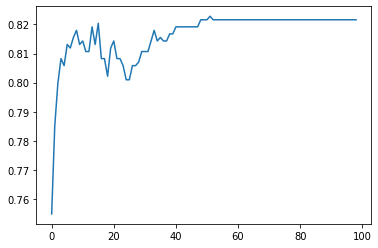

In [350]:
import matplotlib.pyplot as plt
plt.plot(validation_scores)

In [42]:
knn = KNN(k=1000)
knn.fit(Xtrain, Ytrain)

In [21]:
knn.score(Xtest, Ytest)

0.9134295227524972

In [43]:
knn.score(Xtrain, Ytrain)

0.6919362626750362

In [44]:
knn = KNN(k=1)
knn.fit(Xtrain, Ytrain)
knn.score(Xtrain, Ytrain)

1.0

We also ran the same code to get an idea of how sklearn's implementation would behave with varying values of k. The graph looks basically the same which means that our model makes sense. The slight differences is likely due to small things that sklearn includes in their implementation to make it more efficient (ball tree) and the use of weights etc.

In [34]:
from sklearn.neighbors import KNeighborsClassifier
validation_scores = []
for i in range(1,100):
    knn = KNeighborsClassifier(n_neighbors=i*20)
    knn.fit(Xtrain, Ytrain)
    validation_scores.append(knn.score(Xvalidation, Yvalidation))

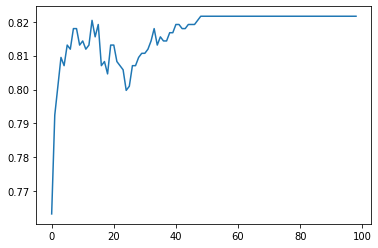

In [35]:
import matplotlib.pyplot as plt
plt.plot(validation_scores)

# Implementation using Ball Trees

This was just implemented for fun to see the difference in speed (this method was of course computationally quicker).

In [263]:
from sklearn.metrics import accuracy_score
from sklearn.neighbors import BallTree
from collections import Counter
import numpy as np

class KNN_ball_tree:
    def __init__(self, k):
        self.k = k
        self.is_fitted = False
        
    def distance(x1, x2):
        return numpy.linalg.norm(x1-x2)
        
        """
        Parameters:
            x: input data of dimension (n_samples, n_features)
            y: output data of dimension (n_samples, 1)
        """
    def fit(self, x, y):
        if self.k > x.shape[0]:
            raise RuntimeError("Error: k must be smaller than the number of samples.")
            
        if x.shape[0] != y.shape[0]:
            raise RuntimeError("Error: dimensions of x and y not matching.")
            
        self.y = y.values
        self.x = x
        self.x_ball = BallTree(Xtrain)
        self.is_fitted = True
        return self
        
    
    def predict(self, x):
        if not self.is_fitted:
            raise RuntimeError("Error: Model not fitted.")
        result = []
        _, ind = self.x_ball.query(x, k=self.k)
        j = 0
        for i in ind:
            result.append(Counter(self.y[i.flatten()]).most_common()[0][0])
            j += 1
        return np.array(result)
            
        pass
    
    def score(self, x, y):
        if not self.is_fitted:
            raise RuntimeError("Error: Model not fitted.")
            
        return accuracy_score(self.predict(x), y)

In [264]:
knn_ball = KNN_ball_tree(12)

In [265]:
knn_ball.fit(Xtrain, Ytrain)

In [266]:
knn_ball.score(Xtest, Ytest)

0.633370329263781